In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymcr
from pymcr.mcr import McrAR
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
import torch

from pymcr_torch_demo import torch_model as tm


print("Python version: ", sys.version)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("pymcr version: ", pymcr.__version__)
print("torch version", torch.__version__)

Python version:  3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
numpy version:  2.1.3
matplotlib version:  3.9.2
pymcr version:  0.5.1
torch version 2.5.1


In [3]:
random.seed(717)
np.random.seed(717)
torch.manual_seed(717)

In [4]:
torch.set_default_dtype(torch.float64)

In [5]:
with open("../data/ethanol/ethanol-mcr.npz", "rb") as ethanol_mcr_file:
    ethanol_mcr = np.load(ethanol_mcr_file)

    D = ethanol_mcr["D"]
    C = ethanol_mcr["C"]
    ST = ethanol_mcr["ST"]
    wavelengths = ethanol_mcr["wavelengths"]

    print(ethanol_mcr)

NpzFile 'object' with keys: D, C, ST, wavelengths


In [6]:
print(
    f"D shape: {D.shape}\nC shape: {C.shape}\nST shape{ST.shape}\nwavelengths shape: {wavelengths.shape}"
)

D shape: (55, 2301)
C shape: (55, 2)
ST shape(2, 2301)
wavelengths shape: (2301,)


## Predicting Concentrations from Pure Spectra

The fit errors due to the mean-squared error increasing above the tolerance. From what I understand, this means it finds the optimal value very quickly.

In [7]:
mcrar = McrAR(
    max_iter=100,
    st_regr=tm.AutoEncoderAxB(),
    c_regr=tm.TorchLeastSquares(),
    c_constraints=[ConstraintNonneg(), ConstraintNorm()],
    tol_increase=100.0,
)
mcrar.fit(D=D, ST=ST, verbose=True)

Iter: 1 (C)	mse: 2.9061e-04
Iter: 1 (ST)	mse: 1.4916e-04
Iter: 2 (C)	mse: 1.4991e-04
Iter: 2 (ST)	mse: 1.4954e-04
Iter: 3 (C)	mse: 1.4961e-04
Iter: 3 (ST)	mse: 1.4917e-04
Iter: 4 (C)	mse: 1.4921e-04
Iter: 4 (ST)	mse: 1.4964e-04
Iter: 5 (C)	mse: 1.4969e-04
Iter: 5 (ST)	mse: 1.4913e-04
Iter: 6 (C)	mse: 1.4912e-04
Iter: 6 (ST)	mse: 1.6597e-04
Iter: 7 (C)	mse: 1.6589e-04
Iter: 7 (ST)	mse: 1.4904e-04
Iter: 8 (C)	mse: 1.4899e-04
Iter: 8 (ST)	mse: 1.4898e-04
Iter: 9 (C)	mse: 1.4901e-04
Iter: 9 (ST)	mse: 1.6127e-04
Iter: 10 (C)	mse: 1.6092e-04
Iter: 10 (ST)	mse: 1.4937e-04
Iter: 11 (C)	mse: 1.4938e-04
Iter: 11 (ST)	mse: 1.4903e-04
Iter: 12 (C)	mse: 1.4909e-04
Iter: 12 (ST)	mse: 1.4907e-04
Iter: 13 (C)	mse: 1.4911e-04
Iter: 13 (ST)	mse: 1.4910e-04
Half-iterated 11 times since min error. Exiting.


Text(0.5, 1.0, 'MCR-ALS Predictions based on Pure Spectra')

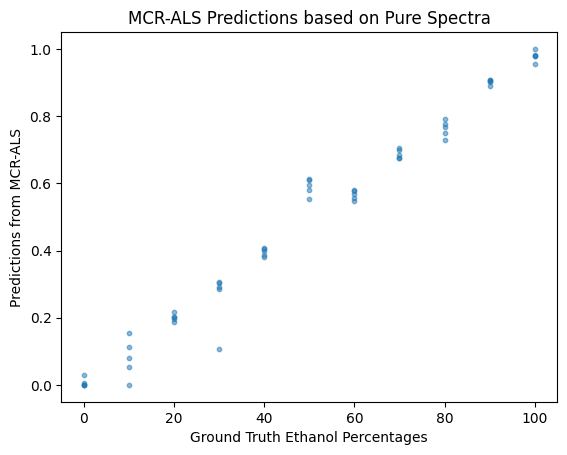

In [8]:
# I think its random whjch axis in C_opt_ gets which concentration
plt.scatter(x=C[:, 0], y=mcrar.C_opt_[:, 1], s=10, alpha=0.5)
plt.ylabel("Predictions from MCR-ALS")
plt.xlabel("Ground Truth Ethanol Percentages")
plt.title("MCR-ALS Predictions based on Pure Spectra")

## Predicting Pure Spectra from Concentration data

In this example I leave out the pure water and ethanol spectra that we already know. In the data matrix, these are the first 5 and last 5 samples. The 

In [9]:
mcrar = McrAR(
    max_iter=100,
    st_regr=tm.AutoEncoderAxB(),
    c_regr=tm.TorchLeastSquares(),
    # c_constraints=[ConstraintNonneg(), ConstraintNorm()],
    tol_increase=100.0,
)
mcrar.fit(D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True)

Iter: 1 (ST)	mse: 1.2729e-04
Iter: 2 (C)	mse: 1.0964e-04
Iter: 2 (ST)	mse: 1.3428e-04
Iter: 3 (C)	mse: 1.2379e-04
Iter: 3 (ST)	mse: 1.0926e-04
Iter: 4 (C)	mse: 1.0912e-04
Iter: 4 (ST)	mse: 1.0991e-04
Iter: 5 (C)	mse: 1.0971e-04
Iter: 5 (ST)	mse: 1.0916e-04
Iter: 6 (C)	mse: 1.0888e-04
Iter: 6 (ST)	mse: 1.0882e-04
Iter: 7 (C)	mse: 1.0873e-04
Iter: 7 (ST)	mse: 1.0825e-04
Iter: 8 (C)	mse: 1.0820e-04
Iter: 8 (ST)	mse: 1.0807e-04
Iter: 9 (C)	mse: 1.0803e-04
Iter: 9 (ST)	mse: 1.0809e-04
Iter: 10 (C)	mse: 1.0804e-04
Iter: 10 (ST)	mse: 1.1260e-04
Iter: 11 (C)	mse: 1.1256e-04
Iter: 11 (ST)	mse: 1.0793e-04
Iter: 12 (C)	mse: 1.0791e-04
Iter: 12 (ST)	mse: 1.0789e-04
Iter: 13 (C)	mse: 1.0787e-04
Iter: 13 (ST)	mse: 1.0786e-04
Iter: 14 (C)	mse: 1.0785e-04
Iter: 14 (ST)	mse: 1.0784e-04
Iter: 15 (C)	mse: 1.0783e-04
Iter: 15 (ST)	mse: 1.0782e-04
Iter: 16 (C)	mse: 1.0781e-04
Iter: 16 (ST)	mse: 1.0780e-04
Iter: 17 (C)	mse: 1.0780e-04
Iter: 17 (ST)	mse: 1.0779e-04
Iter: 18 (C)	mse: 1.0779e-04
Iter: 18 (ST)	

Text(0.5, 0, 'Wavelength (nm)')

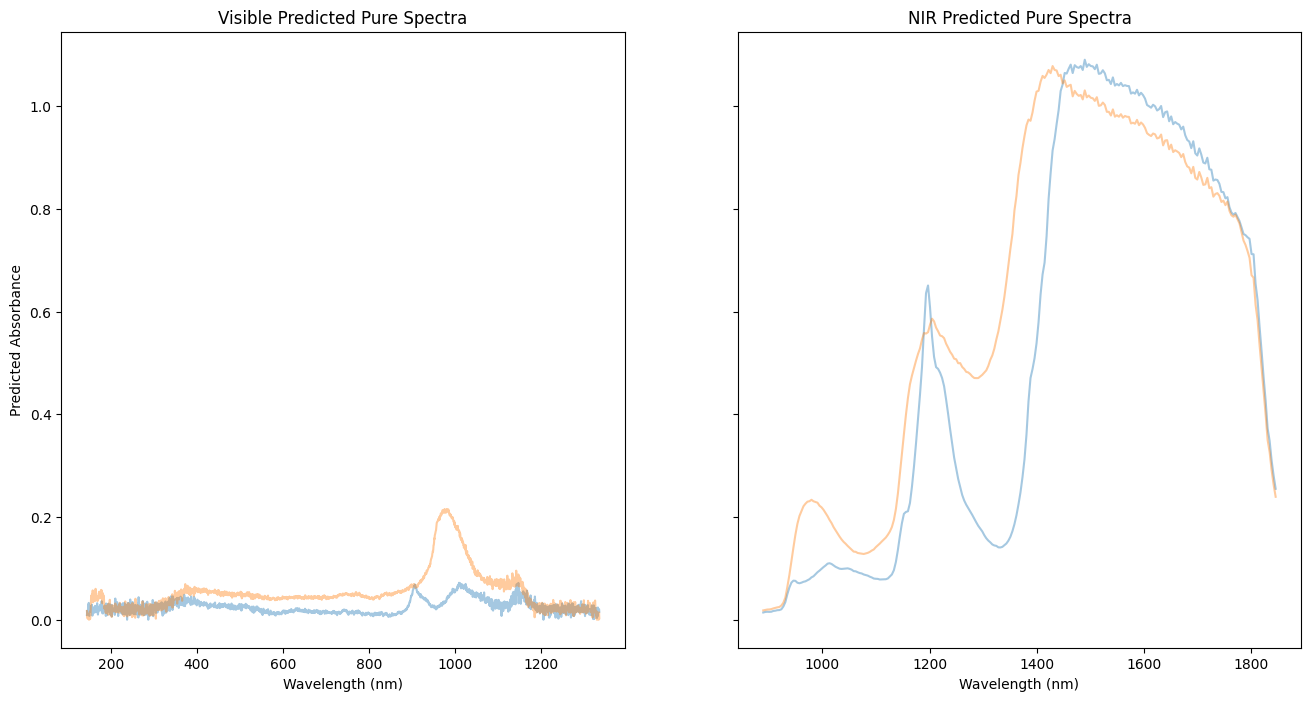

In [10]:
vis_cols = [
    float(col.split("_")[1]) for col in wavelengths if "avaspec" in col
]
nir_cols = [
    float(col.split("_")[1]) for col in wavelengths if "hamamatsu" in col
]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

ax[0].plot(
    vis_cols,
    mcrar.ST_opt_[0, :2048],
    alpha=0.4,
)
ax[0].plot(
    vis_cols,
    mcrar.ST_opt_[1, :2048],
    alpha=0.4,
)

ax[1].plot(
    nir_cols,
    mcrar.ST_opt_[0, 2048:],
    alpha=0.4,
)
ax[1].plot(
    nir_cols,
    mcrar.ST_opt_[1, 2048:],
    alpha=0.4,
)

ax[1].set_title("NIR Predicted Pure Spectra")
ax[0].set_title("Visible Predicted Pure Spectra")
ax[0].set_ylabel("Predicted Absorbance")
ax[0].set_xlabel("Wavelength (nm)")
ax[1].set_xlabel("Wavelength (nm)")

## Lowering the learning rate to 0.001 and additional constraint

Iter: 1 (ST)	mse: 8.2852e-02
Iter: 2 (C)	mse: 6.4989e-02
Iter: 2 (ST)	mse: 5.5668e-02
Iter: 3 (C)	mse: 5.5765e-02
Iter: 3 (ST)	mse: 5.3515e-02
Iter: 4 (C)	mse: 5.3447e-02
Iter: 4 (ST)	mse: 5.1415e-02
Iter: 5 (C)	mse: 5.0942e-02
Iter: 5 (ST)	mse: 4.7422e-02
Iter: 6 (C)	mse: 4.6163e-02
Iter: 6 (ST)	mse: 3.9922e-02
Iter: 7 (C)	mse: 3.7569e-02
Iter: 7 (ST)	mse: 2.8491e-02
Iter: 8 (C)	mse: 2.5307e-02
Iter: 8 (ST)	mse: 1.5665e-02
Iter: 9 (C)	mse: 1.2993e-02
Iter: 9 (ST)	mse: 6.3744e-03
Iter: 10 (C)	mse: 5.2186e-03
Iter: 10 (ST)	mse: 2.3710e-03
Iter: 11 (C)	mse: 2.0714e-03
Iter: 11 (ST)	mse: 1.0428e-03
Iter: 12 (C)	mse: 9.7546e-04
Iter: 12 (ST)	mse: 5.3067e-04
Iter: 13 (C)	mse: 5.1359e-04
Iter: 13 (ST)	mse: 2.8562e-04
Iter: 14 (C)	mse: 2.7866e-04
Iter: 14 (ST)	mse: 1.7170e-04
Iter: 15 (C)	mse: 1.6765e-04
Iter: 15 (ST)	mse: 1.2895e-04
Iter: 16 (C)	mse: 1.2724e-04
Iter: 16 (ST)	mse: 1.1591e-04
Iter: 17 (C)	mse: 1.1540e-04
Iter: 17 (ST)	mse: 1.1184e-04
Iter: 18 (C)	mse: 1.1171e-04
Iter: 18 (ST)	

Text(0.5, 0, 'Wavelength (nm)')

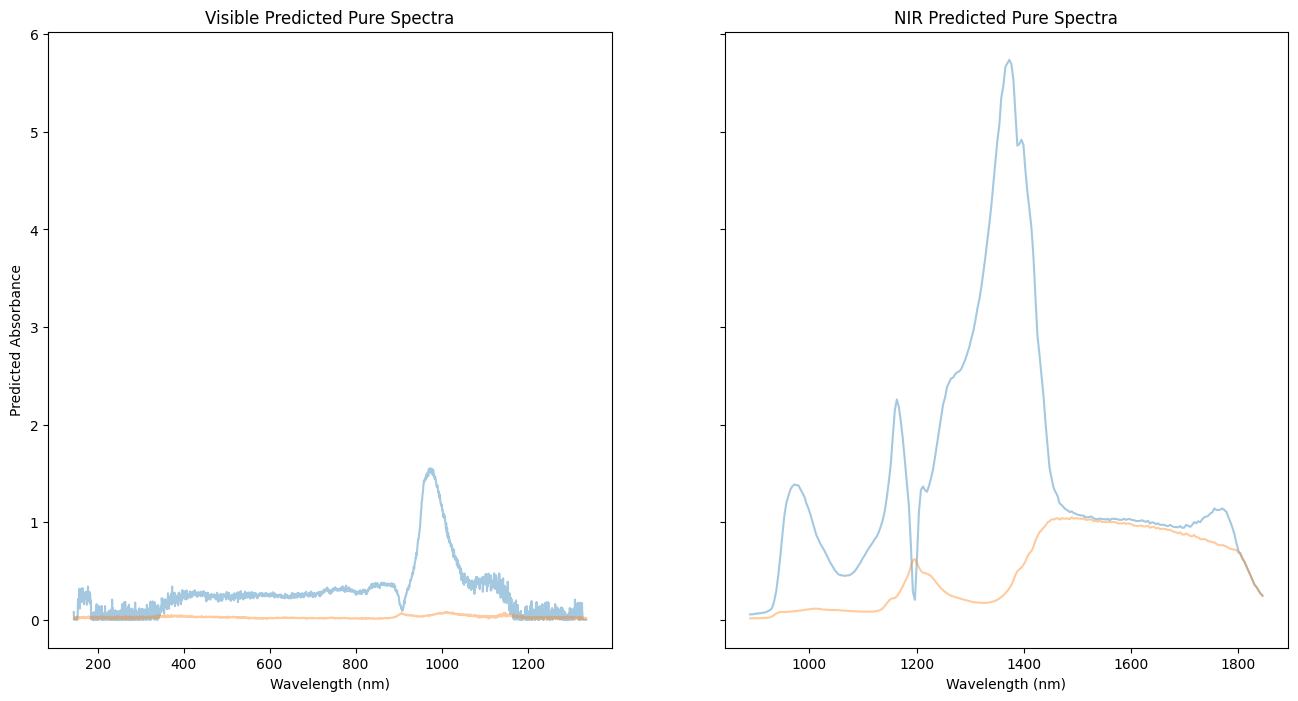

In [11]:
mcrar = McrAR(
    max_iter=1000,
    st_regr=tm.TorchGrad(lr=0.001),
    c_regr=tm.TorchLeastSquares(),
    c_constraints=[ConstraintNonneg(), ConstraintNorm()],
    tol_increase=100.0,
)
mcrar.fit(D=D[5:-5, :], C=C[5:-5, :] / 100, verbose=True)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

ax[0].plot(
    vis_cols,
    mcrar.ST_opt_[0, :2048],
    alpha=0.4,
)
ax[0].plot(
    vis_cols,
    mcrar.ST_opt_[1, :2048],
    alpha=0.4,
)

ax[1].plot(
    nir_cols,
    mcrar.ST_opt_[0, 2048:],
    alpha=0.4,
)
ax[1].plot(
    nir_cols,
    mcrar.ST_opt_[1, 2048:],
    alpha=0.4,
)

ax[1].set_title("NIR Predicted Pure Spectra")
ax[0].set_title("Visible Predicted Pure Spectra")
ax[0].set_ylabel("Predicted Absorbance")
ax[0].set_xlabel("Wavelength (nm)")
ax[1].set_xlabel("Wavelength (nm)")